In [1]:
import os
import json
import torch
import torch.nn.functional as F
import random
import time
from transformers import RobertaTokenizer, RobertaModel
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier as SklearnMLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import numpy as np
import datetime
import time
from tqdm import tqdm
import random

In [2]:
### 选择gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#### 参数配置
projectionHeadEpoch=100                   
beforeProjectionEpoch=30                  
afterProjectionEpoch=30
Temperature=0.2
projectionHeadPatience=2
beforeProjectionPatience=2
afterProjectionPatience=2
index=5        
lang=3
Trainsize=100
lr1=3e-6
lr2=1e-6
lr3=1e-6
Pre_fig_tilte='testSize_1027'
ProjectionBatchSize=1                   
BatchSize=64
ExpertsNum=8

In [4]:
# 加载模型和tokenizer
modelType=['codebert-base','codeExecutor','CodeReviewer','graphCodeBert','longcoder-base','unixcoder']
modelPath='../../model/'+modelType[index]+'/'
tokenizer = AutoTokenizer.from_pretrained(modelPath)
model = AutoModel.from_pretrained(modelPath).to(device)
print(model)

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(51416, 768, padding_idx=1)
    (position_embeddings): Embedding(1026, 768, padding_idx=1)
    (token_type_embeddings): Embedding(10, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (drop

In [5]:
# 加载并处理样本数据
langType=['code_pairs_cpp_python.jsonl','code_pairs_java_c.jsonl','code_pairs_java_cs.jsonl','code_pairs_java_python.jsonl']
langPath='../../Datasets/'+langType[lang]
def load_samples_from_jsonl(file_path, max_samples=Trainsize):
    samples = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            record = json.loads(line.strip())
            samples.append(record)
            if len(samples) >= max_samples:
                break
    return samples

samples = load_samples_from_jsonl(langPath)
print(langType[lang])

code_pairs_java_python.jsonl


In [6]:
# 对样本数据进行编码
def encode_sample(sample, tokenizer, model, device, max_length=512):
    code_inputs = tokenizer(sample['code'], return_tensors='pt', padding='max_length', truncation=True,max_length=max_length).to(device)
    with torch.no_grad():
        code_embedding = model(**code_inputs).last_hidden_state.mean(dim=1).cpu()
    positive_embeddings = []
    for positive_sample in sample['positive']['code_positive']:
        pos_inputs = tokenizer(positive_sample['code'], return_tensors='pt', padding='max_length', truncation=True,max_length=max_length).to(device)
        with torch.no_grad():
            pos_embedding = model(**pos_inputs).last_hidden_state.mean(dim=1).cpu()
        positive_embeddings.append(pos_embedding)
    negative_embeddings = []
    for negative_sample in sample['negative']['code_negative']:
        neg_inputs = tokenizer(negative_sample['code'], return_tensors='pt', padding='max_length', truncation=True,max_length=max_length).to(device)
        with torch.no_grad():
            neg_embedding = model(**neg_inputs).last_hidden_state.mean(dim=1).cpu()
        negative_embeddings.append(neg_embedding)
    return {
        'code_embedding': code_embedding,
        'positive_embeddings': positive_embeddings,
        'negative_embeddings': negative_embeddings
    }
encoded_samples = [encode_sample(sample, tokenizer, model, device) for sample in samples]

In [7]:
class ConbaLayer(nn.Module):
    def __init__(self, input_dim):
        super(ConbaLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.selective_fc = nn.Linear(input_dim, input_dim)
        self.swish = nn.SiLU()
        
        # 控制参数
        self.control_weight = nn.Parameter(torch.ones(input_dim))  # 可学习的权重参数
        self.feedback_weight = nn.Parameter(torch.ones(input_dim))  # 反馈控制权重
        
        # 状态空间参数
        self.A = nn.Linear(input_dim, input_dim, bias=False)  # 线性部分
        self.B = nn.Linear(input_dim, input_dim, bias=False)  # 非线性部分
        self.C = nn.Linear(input_dim, input_dim, bias=False)  # 输出映射

        self.fc2 = nn.Linear(input_dim, input_dim)
        
    def forward(self, x, previous_state=None):
        if previous_state is None:
            previous_state = torch.zeros_like(x, device=x.device)
        # 状态更新：使用状态空间模型计算当前状态
        state = self.A(previous_state) + self.B(x)
        
        # 选择性激活和反馈控制
        selective_output = self.swish(self.selective_fc(x)) * x
        adjusted_output = selective_output * self.control_weight + state * self.feedback_weight
        
        # 输出层
        output = self.C(adjusted_output)
        output = self.fc2(output)
        return output, state  # 返回当前输出和更新后的状态


class SimCLRWithConba(nn.Module):
    def __init__(self, input_dim=768):
        super(SimCLRWithConba, self).__init__()
        self.conba_layer = ConbaLayer(input_dim)

    def forward(self, x, previous_state=None):
        # 传递状态信息到Conba层
        return self.conba_layer(x, previous_state)

contrastive_model = SimCLRWithConba(input_dim=768).to(device)
optimizer = optim.AdamW(contrastive_model.parameters(), lr=1e-4)


In [24]:
contrastive_model

SimCLRWithConba(
  (conba_layer): ConbaLayer(
    (fc1): Linear(in_features=768, out_features=768, bias=True)
    (selective_fc): Linear(in_features=768, out_features=768, bias=True)
    (swish): SiLU()
    (A): Linear(in_features=768, out_features=768, bias=False)
    (B): Linear(in_features=768, out_features=768, bias=False)
    (C): Linear(in_features=768, out_features=768, bias=False)
    (fc2): Linear(in_features=768, out_features=768, bias=True)
  )
)

In [25]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.01
)

In [8]:
def simclr_contrastive_loss(anchor, positives, negatives, temperature=Temperature):
    anchor = F.normalize(anchor, dim=1)
    positives = [F.normalize(pos, dim=1) for pos in positives]
    negatives = [F.normalize(neg, dim=1) for neg in negatives]

    positive_loss = 0
    for pos in positives:
        pos_similarity = torch.exp(torch.mm(anchor, pos.t()) / temperature)
        neg_similarity = sum(torch.exp(torch.mm(anchor, neg.t()) / temperature) for neg in negatives)
        positive_loss += -torch.log(pos_similarity / (pos_similarity + neg_similarity)).mean()

    loss = positive_loss / len(positives)
    return loss

In [9]:
class CodeCloneDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        anchor = sample['code_embedding'].view(1, -1)  # 确保 anchor 是二维矩阵
        positives = [pos.view(1, -1) for pos in sample['positive_embeddings']]  # 确保 positives 是二维矩阵
        negatives = [neg.view(1, -1) for neg in sample['negative_embeddings']]  # 确保 negatives 是二维矩阵
        return anchor, positives, negatives

In [10]:
control_weights_history = []

In [11]:
def train_contrastive_model(encoded_samples, val_encoded_samples, contrastive_model, epochs=100, temperature=Temperature, patience=3):
    global projectionHeadEpoch
    global control_weights_history
    train_dataset = CodeCloneDataset(encoded_samples)
    val_dataset = CodeCloneDataset(val_encoded_samples)
    
    train_dataloader = DataLoader(train_dataset, batch_size=ProjectionBatchSize, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=ProjectionBatchSize, shuffle=False)
    
    optimizer = torch.optim.Adam(contrastive_model.parameters(), lr=lr1)
    
    contrastive_model.train()
    losses = []
    val_losses = []
    train_metrics = []
    val_metrics = []
    best_val_loss = float('inf')
    no_improvement_count = 0
    start_time = time.time()
    
    for epoch in range(epochs):
        total_loss = 0
        all_train_labels = []
        all_train_preds = []
        
        contrastive_model.train()
        
        for i, (anchor, positives, negatives) in enumerate(train_dataloader):
            optimizer.zero_grad()
            anchor = anchor.to(device)
            positives = [pos.to(device) for pos in positives]
            negatives = [neg.to(device) for neg in negatives]
            
            # 初始化状态
            previous_state_anchor = None
            previous_states_positives = [None] * len(positives)
            previous_states_negatives = [None] * len(negatives)
            
            # 前向传播并更新状态
            anchor, state_anchor = contrastive_model(anchor, previous_state_anchor)
            positives = [contrastive_model(pos, state)[0] for pos, state in zip(positives, previous_states_positives)]
            negatives = [contrastive_model(neg, state)[0] for neg, state in zip(negatives, previous_states_negatives)]
            
            anchor = anchor.view(anchor.size(0), -1).to(device)
            positives = [pos.view(pos.size(0), -1).to(device) for pos in positives]
            negatives = [neg.view(neg.size(0), -1).to(device) for neg in negatives]
            
            # 计算损失
            loss = simclr_contrastive_loss(anchor, positives, negatives, temperature)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # 计算训练集的预测标签和真实标签
            for pos in positives:
                similarity = F.cosine_similarity(anchor, pos, dim=1).detach().cpu().numpy()
                all_train_preds.extend((similarity > 0.5).astype(int))
                all_train_labels.extend([1] * len(similarity))
                
            for neg in negatives:
                similarity = F.cosine_similarity(anchor, neg, dim=1).detach().cpu().numpy()
                all_train_preds.extend((similarity <= 0.5).astype(int))
                all_train_labels.extend([0] * len(similarity))
        
        avg_train_loss = total_loss / len(train_dataloader)
        losses.append(avg_train_loss)
        
        # 计算训练集指标
        train_acc = accuracy_score(all_train_labels, all_train_preds)
        train_f1 = f1_score(all_train_labels, all_train_preds)
        train_recall = recall_score(all_train_labels, all_train_preds)
        train_precision = precision_score(all_train_labels, all_train_preds)
        train_metrics.append((train_acc, train_f1, train_recall, train_precision))
        print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss}',end=' ')       
        # print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss}, Train ACC: {train_acc}, Train F1: {train_f1}, Train Recall: {train_recall}, Train Precision: {train_precision}')

        # 记录控制权重
        current_control_weights = contrastive_model.conba_layer.control_weight.detach().cpu().numpy()
        control_weights_history.append(current_control_weights)
        
        # 验证集评估
        contrastive_model.eval()
        total_val_loss = 0
        all_val_labels = []
        all_val_preds = []
        
        with torch.no_grad():
            for i, (anchor, positives, negatives) in enumerate(val_dataloader):
                anchor = anchor.to(device)
                positives = [pos.to(device) for pos in positives]
                negatives = [neg.to(device) for neg in negatives]
                
                previous_state_anchor = None
                previous_states_positives = [None] * len(positives)
                previous_states_negatives = [None] * len(negatives)
                
                anchor, state_anchor = contrastive_model(anchor, previous_state_anchor)
                positives = [contrastive_model(pos, state)[0] for pos, state in zip(positives, previous_states_positives)]
                negatives = [contrastive_model(neg, state)[0] for neg, state in zip(negatives, previous_states_negatives)]
                
                anchor = anchor.view(anchor.size(0), -1).to(device)
                positives = [pos.view(pos.size(0), -1).to(device) for pos in positives]
                negatives = [neg.view(neg.size(0), -1).to(device) for neg in negatives]
                
                val_loss = simclr_contrastive_loss(anchor, positives, negatives, temperature)
                total_val_loss += val_loss.item()
                
                # 计算验证集的预测标签和真实标签
                for pos in positives:
                    similarity = F.cosine_similarity(anchor, pos, dim=1).detach().cpu().numpy()
                    all_val_preds.extend((similarity > 0.5).astype(int))
                    all_val_labels.extend([1] * len(similarity))
                    
                for neg in negatives:
                    similarity = F.cosine_similarity(anchor, neg, dim=1).detach().cpu().numpy()
                    all_val_preds.extend((similarity <= 0.5).astype(int))
                    all_val_labels.extend([0] * len(similarity))
        
        avg_val_loss = total_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        
        # 计算验证集指标
        val_acc = accuracy_score(all_val_labels, all_val_preds)
        val_f1 = f1_score(all_val_labels, all_val_preds)
        val_recall = recall_score(all_val_labels, all_val_preds)
        val_precision = precision_score(all_val_labels, all_val_preds)
        val_metrics.append((val_acc, val_f1, val_recall, val_precision))
        print(f'Validation Loss: {avg_val_loss}')
        # 
        # print(f'Validation Loss: {avg_val_loss}, Validation ACC: {val_acc}, Validation F1: {val_f1}, Validation Recall: {val_recall}, Validation Precision: {val_precision}')
        
        # 早停法逻辑
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            if no_improvement_count >= patience:
                projectionHeadEpoch=epoch+1
                print(f'Early stopping triggered after {epoch + 1} epochs.')
                break
        
        torch.cuda.empty_cache()
    
    end_time = time.time()
    training_time = end_time - start_time
    return losses, val_losses, train_metrics, val_metrics, training_time


In [12]:
def evaluate_clones(samples, model, contrastive_model=None, mlp_model=None):
    model.eval()
    if contrastive_model:
        contrastive_model.eval()
    if mlp_model:
        mlp_model.eval()

    all_labels = []
    all_preds = []

    start_time = time.time()  # 记录预测开始时间

    for sample in samples:
        anchor = sample['code_embedding'].squeeze().to(device)  # 确保 anchor 是二维矩阵
        positives = [pos.squeeze().to(device) for pos in sample['positive_embeddings']]  # 确保 positives 是二维矩阵
        negatives = [neg.squeeze().to(device) for neg in sample['negative_embeddings']]  # 确保 negatives 是二维矩阵

        if contrastive_model:
            with torch.no_grad():
                anchor, _ = contrastive_model(anchor)  # 仅获取output，忽略state
                positives = [contrastive_model(pos)[0] for pos in positives]  # 获取output
                negatives = [contrastive_model(neg)[0] for neg in negatives]  # 获取output

        ######### 包含MLP作为克隆检测器
        if mlp_model:
            with torch.no_grad():
                for pos in positives:
                    output = mlp_model(anchor, pos)
                    all_labels.append(1)
                    all_preds.append(torch.argmax(output).item())
                for neg in negatives:
                    output = mlp_model(anchor, neg)
                    all_labels.append(0)
                    all_preds.append(torch.argmax(output).item())
        else:   ################ 不含MLP作为克隆检测器,直接用阈值判断
            for pos in positives:
                similarity = F.cosine_similarity(anchor, pos, dim=0).item()
                all_labels.append(1)
                all_preds.append(1 if similarity > 0.5 else 0)

            for neg in negatives:
                similarity = F.cosine_similarity(anchor, neg, dim=0).item()
                all_labels.append(0)
                all_preds.append(0 if similarity <= 0.5 else 1)

    end_time = time.time()  # 记录预测结束时间
    prediction_time = end_time - start_time  # 计算预测时间

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    return acc, f1, recall, precision, prediction_time


In [13]:
# 将数据集分为训练集和测试集
train_samples, remaining_samples = train_test_split(encoded_samples, test_size=0.4, random_state=42)
# 第二次分割：将剩余部分分为验证集和测试集
val_samples, test_samples = train_test_split(remaining_samples, test_size=0.5, random_state=42)

In [14]:
#### ProjectionHead训练模型
contrastive_losses, val_losses, train_metrics, val_metrics, contrastive_training_time = train_contrastive_model(
    train_samples, val_samples, 
    contrastive_model,
    projectionHeadEpoch,
    Temperature,
    projectionHeadPatience
)

Epoch 1, Train Loss: 2.1558792014916737 Validation Loss: 1.9706211626529693
Epoch 2, Train Loss: 1.7919614334901175 Validation Loss: 1.661103442311287
Epoch 3, Train Loss: 1.4515993823607762 Validation Loss: 1.3978682726621627
Epoch 4, Train Loss: 1.1725986470778784 Validation Loss: 1.1819626435637474
Epoch 5, Train Loss: 0.9507186611493429 Validation Loss: 1.0171522796154022
Epoch 6, Train Loss: 0.7787450628976027 Validation Loss: 0.8873121812939644
Epoch 7, Train Loss: 0.6435930783549945 Validation Loss: 0.7820738404989243
Epoch 8, Train Loss: 0.5358674474060535 Validation Loss: 0.702998785674572
Epoch 9, Train Loss: 0.45444148822377123 Validation Loss: 0.636741290986538
Epoch 10, Train Loss: 0.38725551310926676 Validation Loss: 0.58715885207057
Epoch 11, Train Loss: 0.3339613995204369 Validation Loss: 0.5443927295506
Epoch 12, Train Loss: 0.29248172768081226 Validation Loss: 0.5108218654990196
Epoch 13, Train Loss: 0.2580971725595494 Validation Loss: 0.4829285223037004
Epoch 14, Tra

In [15]:
contrastive_acc, contrastive_f1, contrastive_recall,contrastive_precision ,contrastive_prediction_time = evaluate_clones(test_samples, model, contrastive_model)
print(
    f'Contrastive Learning Embedding - ACC: {contrastive_acc},'
    f' F1: {contrastive_f1},'
    f' Recall: {contrastive_recall},'
    f'Precision:{contrastive_precision}'
)

Contrastive Learning Embedding - ACC: 0.9678571428571429, F1: 0.9669522643818849, Recall: 0.9404761904761905,Precision:0.9949622166246851


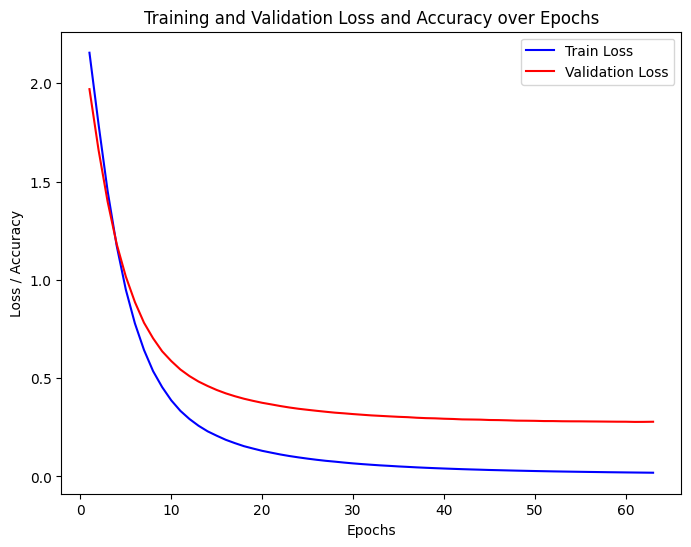

In [23]:
train_losses = contrastive_losses
val_losses = val_losses
train_acc = [metrics[0] for metrics in train_metrics]
val_acc = [metrics[0] for metrics in val_metrics]
epochs = range(1, projectionHeadEpoch+1 )  # 使用 1 到 projectionHeadEpoch 的序列
# print(train_acc)

# 绘制训练过程中的损失和准确率曲线
plt.style.use('default')
plt.figure(figsize=(8, 6))
plt.tight_layout()
# plt.figure(figsize=(14, 8))
# plt.style.use('default')
# 绘制损失曲线
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='red')
# 绘制准确率曲线
# plt.plot(epochs, train_acc, label='Train Accuracy', color='green')
# plt.plot(epochs, val_acc, label='Validation Accuracy', color='purple')

# 添加图例、标题和轴标签
plt.legend(loc='upper right')
plt.title("Training and Validation Loss and Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss / Accuracy")
plt.savefig('test2.png')
# plt.grid(True)
plt.show()


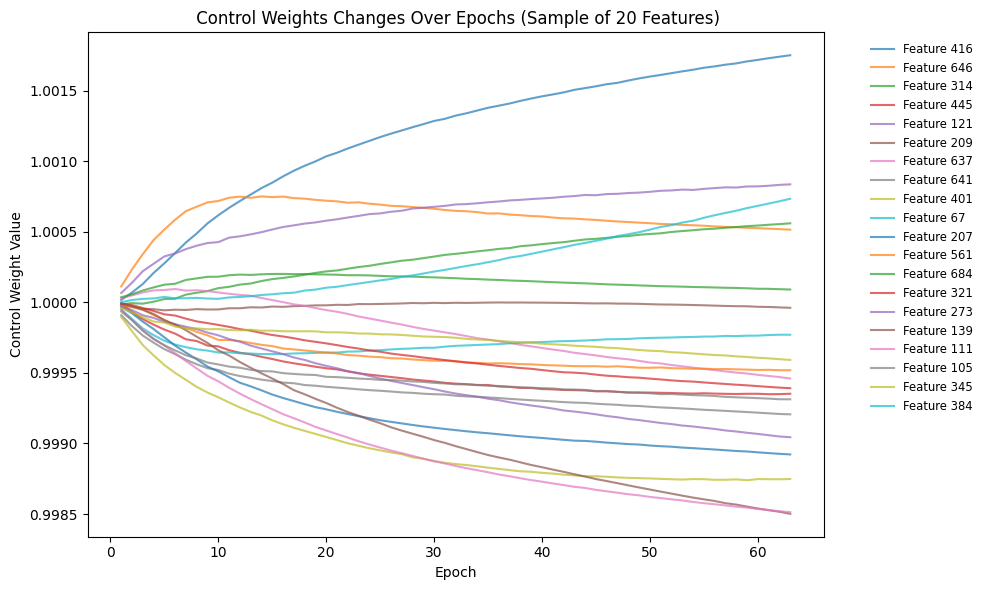

In [17]:
# 绘制控制权重的变化曲线
def plot_control_weights(control_weights_history, num_features_to_plot=20):
    plt.figure(figsize=(10, 6))
    num_epochs = len(control_weights_history)
    num_total_features = len(control_weights_history[0])

    # 随机选择 num_features_to_plot 个特征进行绘制
    sampled_features = random.sample(range(num_total_features), num_features_to_plot)

    # 绘制采样特征的控制权重变化
    for feature_idx in sampled_features:
        feature_weights = [epoch_weights[feature_idx] for epoch_weights in control_weights_history]
        plt.plot(range(1, num_epochs + 1), feature_weights, label=f'Feature {feature_idx + 1}', alpha=0.7)

    plt.xlabel('Epoch')
    plt.ylabel('Control Weight Value')
    plt.title(f' Control Weights Changes Over Epochs (Sample of {num_features_to_plot} Features)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, fontsize='small', frameon=False)
    plt.tight_layout()
    plt.savefig(Pre_fig_tilte+'Control Weights Changes Over Epochs'+".png")
    plt.show()

# 绘制控制权重变化 (采样 20 个特征)
plot_control_weights(control_weights_history, num_features_to_plot=20)

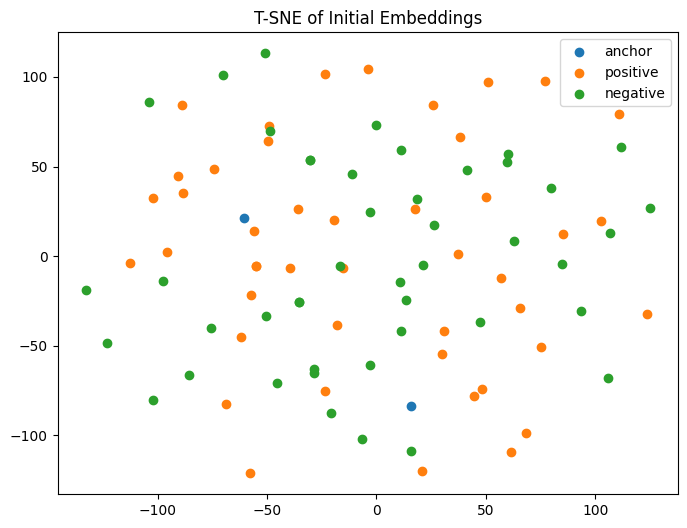

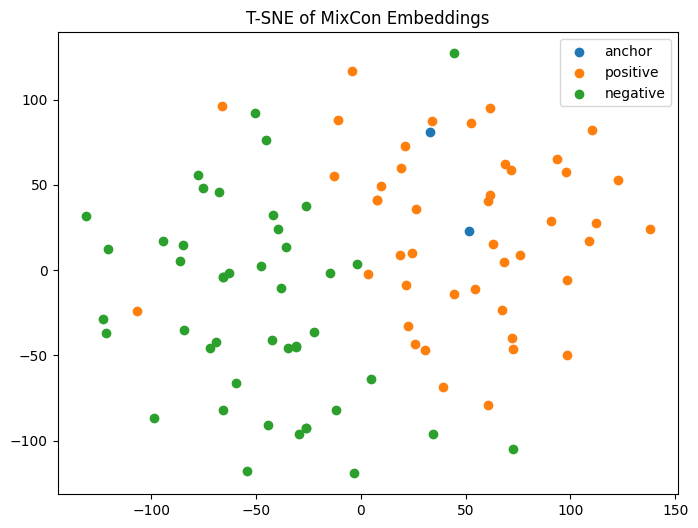

In [21]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import time
import torch

def plot_tsne(samples, contrastive_model=None, title=''):
    embeddings = []
    labels = []
    cnt = 0
    for sample in samples:
        anchor = sample['code_embedding'].squeeze().numpy()
        embeddings.append(anchor)
        labels.append('anchor')
        for pos in sample['positive_embeddings']:
            embeddings.append(pos.squeeze().numpy())
            labels.append('positive')
        for neg in sample['negative_embeddings']:
            embeddings.append(neg.squeeze().numpy())
            labels.append('negative')
        cnt += 1
        if cnt == 2:  # 只取前两个样本
            break
    
    # 转换 embeddings 为对比学习后的嵌入
    if contrastive_model:
        contrastive_model.eval()
        with torch.no_grad():
            embeddings = contrastive_model(torch.tensor(embeddings).to(device))[0].cpu().detach().numpy()

    embeddings = np.array(embeddings)  # 确保 embeddings 是 NumPy 数组

    # 执行 T-SNE 降维
    tsne = TSNE(n_components=3, random_state=42)
    tsne_results = tsne.fit_transform(embeddings)

    # 绘制 T-SNE 图
    plt.figure(figsize=(8, 6))
    for label in ['anchor', 'positive', 'negative']:
        idx = [i for i, lbl in enumerate(labels) if lbl == label]
        plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], label=label)
    plt.legend()
    plt.title(title)
    
    # 保存图像
    plt.savefig(f"{time.time()}_{title}.png")
    plt.show()

# 绘制T-SNE图：对比学习前后的嵌入分布
plot_tsne(test_samples, title='T-SNE of Initial Embeddings')
plot_tsne(test_samples, contrastive_model, title='T-SNE of MixCon Embeddings')
